In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from datetime import datetime, timedelta
import joblib
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 6)

In [4]:
matches = pd.read_csv('./dataset/t20i_Matches_Data.csv')
batting = pd.read_csv('./dataset/t20i_Batting_Card.csv')
bowling = pd.read_csv('./dataset/t20i_Bowling_Card.csv')
players = pd.read_csv('./dataset/players_info.csv')

matches['Match Date'] = pd.to_datetime(matches['Match Date'])
matches = matches.sort_values('Match Date').reset_index(drop=True)

print(f"Matches: {len(matches)}")
print(f"Batting: {len(batting)}")
print(f"Bowling: {len(bowling)}")
print(f"Date Range: {matches['Match Date'].min()} to {matches['Match Date'].max()}")

Matches: 2592
Batting: 56357
Bowling: 30648
Date Range: 2006-06-15 00:00:00 to 2024-05-07 00:00:00


In [5]:
batting_player_match = batting.groupby(['Match ID', 'batsman']).agg({
    'runs': 'sum',
    'balls': 'sum',
    'fours': 'sum',
    'sixes': 'sum',
    'strikeRate': 'mean',
    'isOut': 'max'
}).reset_index()

batting_player_match['strike_rate'] = np.where(
    batting_player_match['balls'] > 0,
    (batting_player_match['runs'] / batting_player_match['balls']) * 100,
    0
)

batting_player_match = batting_player_match.merge(
    matches[['Match ID', 'Match Date', 'Match Venue (City)', 'Match Venue (Country)', 'Team1 Name', 'Team2 Name']],
    on='Match ID',
    how='left'
)

batting_player_match = batting_player_match.sort_values(['batsman', 'Match Date']).reset_index(drop=True)

print(f"Player-Match Batting Records: {len(batting_player_match)}")
batting_player_match.head()

Player-Match Batting Records: 56331


,Match ID,batsman,runs,balls,fours,sixes,strikeRate,isOut,strike_rate,Match Date,Match Venue (City),Match Venue (Country),Team1 Name,Team2 Name
0,255954,1934.0,10.0,12.0,2.0,0.0,83.33,True,83.333333,2006-12-01,Johannesburg,South Africa,South Africa,India
1,211048,1939.0,1.0,4.0,0.0,0.0,25.00,True,25.000000,NaT,Auckland,New Zealand,Australia,New Zealand
2,237242,1939.0,2.0,9.0,0.0,0.0,22.22,True,22.222222,NaT,Auckland,New Zealand,West Indies,New Zealand
3,251487,1979.0,0.0,0.0,0.0,0.0,NaN,False,0.000000,2006-12-22,Wellington,New Zealand,New Zealand,Sri Lanka
4,251488,1979.0,5.0,8.0,0.0,0.0,62.50,True,62.500000,2006-12-26,Auckland,New Zealand,Sri Lanka,New Zealand


In [6]:
bowling_player_match = bowling.groupby(['Match ID', 'bowler id']).agg({
    'overs': 'sum',
    'wickets': 'sum',
    'conceded': 'sum',
    'economy': 'mean',
    'dots': 'sum',
    'maidens': 'sum'
}).reset_index()

bowling_player_match['economy_rate'] = np.where(
    bowling_player_match['overs'] > 0,
    bowling_player_match['conceded'] / bowling_player_match['overs'],
    0
)

bowling_player_match = bowling_player_match.merge(
    matches[['Match ID', 'Match Date', 'Match Venue (City)', 'Match Venue (Country)', 'Team1 Name', 'Team2 Name']],
    on='Match ID',
    how='left'
)

bowling_player_match = bowling_player_match.sort_values(['bowler id', 'Match Date']).reset_index(drop=True)

print(f"Player-Match Bowling Records: {len(bowling_player_match)}")
bowling_player_match.head()

Player-Match Bowling Records: 30622


,Match ID,bowler id,overs,wickets,conceded,economy,dots,maidens,economy_rate,Match Date,Match Venue (City),Match Venue (Country),Team1 Name,Team2 Name
0,255954,1934.0,2.3,1.0,12.0,4.80,8.0,0.0,5.217391,2006-12-01,Johannesburg,South Africa,South Africa,India
1,211048,1939.0,4.0,1.0,28.0,7.00,4.0,0.0,7.000000,NaT,Auckland,New Zealand,Australia,New Zealand
2,237242,1939.0,4.0,0.0,24.0,6.00,7.0,0.0,6.000000,NaT,Auckland,New Zealand,West Indies,New Zealand
3,225271,1988.0,4.0,2.0,32.0,8.00,8.0,0.0,8.000000,2006-06-15,Southampton,England,Sri Lanka,England
4,251487,1988.0,4.0,3.0,21.0,5.25,11.0,0.0,5.250000,2006-12-22,Wellington,New Zealand,New Zealand,Sri Lanka


In [7]:
batting_player_match['career_matches'] = batting_player_match.groupby('batsman').cumcount() + 1
batting_player_match['career_runs'] = batting_player_match.groupby('batsman')['runs'].cumsum()
batting_player_match['career_balls'] = batting_player_match.groupby('batsman')['balls'].cumsum()
batting_player_match['career_fours'] = batting_player_match.groupby('batsman')['fours'].cumsum()
batting_player_match['career_sixes'] = batting_player_match.groupby('batsman')['sixes'].cumsum()

batting_player_match['career_avg'] = batting_player_match['career_runs'] / batting_player_match['career_matches']
batting_player_match['career_sr'] = np.where(
    batting_player_match['career_balls'] > 0,
    (batting_player_match['career_runs'] / batting_player_match['career_balls']) * 100,
    0
)

batting_player_match.head(10)

,Match ID,batsman,runs,balls,fours,sixes,strikeRate,isOut,strike_rate,Match Date,...,Match Venue (Country),Team1 Name,Team2 Name,career_matches,career_runs,career_balls,career_fours,career_sixes,career_avg,career_sr
0,255954,1934.0,10.0,12.0,2.0,0.0,83.33,True,83.333333,2006-12-01,...,South Africa,South Africa,India,1,10.0,12.0,2.0,0.0,10.00,83.333333
1,211048,1939.0,1.0,4.0,0.0,0.0,25.00,True,25.000000,NaT,...,New Zealand,Australia,New Zealand,1,1.0,4.0,0.0,0.0,1.00,25.000000
2,237242,1939.0,2.0,9.0,0.0,0.0,22.22,True,22.222222,NaT,...,New Zealand,West Indies,New Zealand,2,3.0,13.0,0.0,0.0,1.50,23.076923
3,251487,1979.0,0.0,0.0,0.0,0.0,NaN,False,0.000000,2006-12-22,...,New Zealand,New Zealand,Sri Lanka,1,0.0,0.0,0.0,0.0,0.00,0.000000
4,251488,1979.0,5.0,8.0,0.0,0.0,62.50,True,62.500000,2006-12-26,...,New Zealand,Sri Lanka,New Zealand,2,5.0,8.0,0.0,0.0,2.50,62.500000
5,225271,1988.0,41.0,30.0,4.0,2.0,136.66,True,136.666667,2006-06-15,...,England,Sri Lanka,England,1,41.0,30.0,4.0,2.0,41.00,136.666667
6,251487,1988.0,51.0,23.0,10.0,1.0,221.73,False,221.739130,2006-12-22,...,New Zealand,New Zealand,Sri Lanka,2,92.0,53.0,14.0,3.0,46.00,173.584906
7,287860,1988.0,88.0,44.0,11.0,4.0,200.00,True,200.000000,2007-09-14,...,South Africa,Sri Lanka,Kenya,3,180.0,97.0,25.0,7.0,60.00,185.567010
8,287863,1988.0,61.0,44.0,6.0,3.0,138.63,True,138.636364,2007-09-15,...,South Africa,New Zealand,Sri Lanka,4,241.0,141.0,31.0,10.0,60.25,170.921986
9,287868,1988.0,5.0,5.0,0.0,0.0,100.00,True,100.000000,2007-09-17,...,South Africa,Pakistan,Sri Lanka,5,246.0,146.0,31.0,10.0,49.20,168.493151


In [8]:
bowling_player_match['career_matches'] = bowling_player_match.groupby('bowler id').cumcount() + 1
bowling_player_match['career_wickets'] = bowling_player_match.groupby('bowler id')['wickets'].cumsum()
bowling_player_match['career_runs_conceded'] = bowling_player_match.groupby('bowler id')['conceded'].cumsum()
bowling_player_match['career_overs'] = bowling_player_match.groupby('bowler id')['overs'].cumsum()

bowling_player_match['career_avg_wickets'] = bowling_player_match['career_wickets'] / bowling_player_match['career_matches']
bowling_player_match['career_economy'] = np.where(
    bowling_player_match['career_overs'] > 0,
    bowling_player_match['career_runs_conceded'] / bowling_player_match['career_overs'],
    0
)

bowling_player_match.head(10)

,Match ID,bowler id,overs,wickets,conceded,economy,dots,maidens,economy_rate,Match Date,Match Venue (City),Match Venue (Country),Team1 Name,Team2 Name,career_matches,career_wickets,career_runs_conceded,career_overs,career_avg_wickets,career_economy
0,255954,1934.0,2.3,1.0,12.0,4.80,8.0,0.0,5.217391,2006-12-01,Johannesburg,South Africa,South Africa,India,1,1.0,12.0,2.3,1.000000,5.217391
1,211048,1939.0,4.0,1.0,28.0,7.00,4.0,0.0,7.000000,NaT,Auckland,New Zealand,Australia,New Zealand,1,1.0,28.0,4.0,1.000000,7.000000
2,237242,1939.0,4.0,0.0,24.0,6.00,7.0,0.0,6.000000,NaT,Auckland,New Zealand,West Indies,New Zealand,2,1.0,52.0,8.0,0.500000,6.500000
3,225271,1988.0,4.0,2.0,32.0,8.00,8.0,0.0,8.000000,2006-06-15,Southampton,England,Sri Lanka,England,1,2.0,32.0,4.0,2.000000,8.000000
4,251487,1988.0,4.0,3.0,21.0,5.25,11.0,0.0,5.250000,2006-12-22,Wellington,New Zealand,New Zealand,Sri Lanka,2,5.0,53.0,8.0,2.500000,6.625000
5,287860,1988.0,3.0,1.0,9.0,3.00,10.0,0.0,3.000000,2007-09-14,Johannesburg,South Africa,Sri Lanka,Kenya,3,6.0,62.0,11.0,2.000000,5.636364
6,287863,1988.0,4.0,1.0,25.0,6.25,7.0,0.0,6.250000,2007-09-15,Johannesburg,South Africa,New Zealand,Sri Lanka,4,7.0,87.0,15.0,1.750000,5.800000
7,287868,1988.0,4.0,0.0,64.0,16.00,0.0,0.0,16.000000,2007-09-17,Johannesburg,South Africa,Pakistan,Sri Lanka,5,7.0,151.0,19.0,1.400000,7.947368
8,287871,1988.0,1.5,2.0,4.0,2.18,8.0,0.0,2.666667,2007-09-18,Johannesburg,South Africa,Sri Lanka,Bangladesh,6,9.0,155.0,20.5,1.500000,7.560976
9,361658,1988.0,4.0,0.0,33.0,8.25,11.0,0.0,8.250000,2008-10-12,King City,Canada,Sri Lanka,Canada,7,9.0,188.0,24.5,1.285714,7.673469


In [9]:
def calculate_rolling_stats(df, group_col, value_cols, windows=[3, 5, 10]):
    for window in windows:
        for col in value_cols:
            df[f'{col}_last_{window}'] = df.groupby(group_col)[col].transform(
                lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()
            )
    return df

batting_rolling = calculate_rolling_stats(
    batting_player_match.copy(),
    'batsman',
    ['runs', 'strike_rate', 'balls'],
    windows=[3, 5, 10]
)

batting_rolling.head(20)

,Match ID,batsman,runs,balls,fours,sixes,strikeRate,isOut,strike_rate,Match Date,...,career_sr,runs_last_3,strike_rate_last_3,balls_last_3,runs_last_5,strike_rate_last_5,balls_last_5,runs_last_10,strike_rate_last_10,balls_last_10
0,255954,1934.0,10.0,12.0,2.0,0.0,83.33,True,83.333333,2006-12-01,...,83.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,211048,1939.0,1.0,4.0,0.0,0.0,25.00,True,25.000000,NaT,...,25.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,237242,1939.0,2.0,9.0,0.0,0.0,22.22,True,22.222222,NaT,...,23.076923,1.000000,25.000000,4.000000,1.00,25.000000,4.000000,1.000000,25.000000,4.000000
3,251487,1979.0,0.0,0.0,0.0,0.0,NaN,False,0.000000,2006-12-22,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,251488,1979.0,5.0,8.0,0.0,0.0,62.50,True,62.500000,2006-12-26,...,62.500000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
5,225271,1988.0,41.0,30.0,4.0,2.0,136.66,True,136.666667,2006-06-15,...,136.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,251487,1988.0,51.0,23.0,10.0,1.0,221.73,False,221.739130,2006-12-22,...,173.584906,41.000000,136.666667,30.000000,41.00,136.666667,30.000000,41.000000,136.666667,30.000000
7,287860,1988.0,88.0,44.0,11.0,4.0,200.00,True,200.000000,2007-09-14,...,185.567010,46.000000,179.202899,26.500000,46.00,179.202899,26.500000,46.000000,179.202899,26.500000
8,287863,1988.0,61.0,44.0,6.0,3.0,138.63,True,138.636364,2007-09-15,...,170.921986,60.000000,186.135266,32.333333,60.00,186.135266,32.333333,60.000000,186.135266,32.333333
9,287868,1988.0,5.0,5.0,0.0,0.0,100.00,True,100.000000,2007-09-17,...,168.493151,66.666667,186.791831,37.000000,60.25,174.260540,35.250000,60.250000,174.260540,35.250000


In [10]:
bowling_rolling = calculate_rolling_stats(
    bowling_player_match.copy(),
    'bowler id',
    ['wickets', 'economy_rate', 'dots'],
    windows=[3, 5, 10]
)

bowling_rolling.head(20)

,Match ID,bowler id,overs,wickets,conceded,economy,dots,maidens,economy_rate,Match Date,...,career_economy,wickets_last_3,economy_rate_last_3,dots_last_3,wickets_last_5,economy_rate_last_5,dots_last_5,wickets_last_10,economy_rate_last_10,dots_last_10
0,255954,1934.0,2.3,1.0,12.0,4.80,8.0,0.0,5.217391,2006-12-01,...,5.217391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,211048,1939.0,4.0,1.0,28.0,7.00,4.0,0.0,7.000000,NaT,...,7.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,237242,1939.0,4.0,0.0,24.0,6.00,7.0,0.0,6.000000,NaT,...,6.500000,1.000000,7.000000,4.000000,1.00,7.000000,4.000000,1.000000,7.000000,4.000000
3,225271,1988.0,4.0,2.0,32.0,8.00,8.0,0.0,8.000000,2006-06-15,...,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,251487,1988.0,4.0,3.0,21.0,5.25,11.0,0.0,5.250000,2006-12-22,...,6.625000,2.000000,8.000000,8.000000,2.00,8.000000,8.000000,2.000000,8.000000,8.000000
5,287860,1988.0,3.0,1.0,9.0,3.00,10.0,0.0,3.000000,2007-09-14,...,5.636364,2.500000,6.625000,9.500000,2.50,6.625000,9.500000,2.500000,6.625000,9.500000
6,287863,1988.0,4.0,1.0,25.0,6.25,7.0,0.0,6.250000,2007-09-15,...,5.800000,2.000000,5.416667,9.666667,2.00,5.416667,9.666667,2.000000,5.416667,9.666667
7,287868,1988.0,4.0,0.0,64.0,16.00,0.0,0.0,16.000000,2007-09-17,...,7.947368,1.666667,4.833333,9.333333,1.75,5.625000,9.000000,1.750000,5.625000,9.000000
8,287871,1988.0,1.5,2.0,4.0,2.18,8.0,0.0,2.666667,2007-09-18,...,7.560976,0.666667,8.416667,5.666667,1.40,7.700000,7.200000,1.400000,7.700000,7.200000
9,361658,1988.0,4.0,0.0,33.0,8.25,11.0,0.0,8.250000,2008-10-12,...,7.673469,1.000000,8.305556,5.000000,1.40,6.633333,7.200000,1.500000,6.861111,7.333333


In [11]:
batting_rolling['venue_matches'] = batting_rolling.groupby(['batsman', 'Match Venue (City)']).cumcount() + 1
batting_rolling['venue_runs'] = batting_rolling.groupby(['batsman', 'Match Venue (City)'])['runs'].cumsum()
batting_rolling['venue_balls'] = batting_rolling.groupby(['batsman', 'Match Venue (City)'])['balls'].cumsum()

batting_rolling['venue_avg'] = batting_rolling['venue_runs'] / batting_rolling['venue_matches']
batting_rolling['venue_sr'] = np.where(
    batting_rolling['venue_balls'] > 0,
    (batting_rolling['venue_runs'] / batting_rolling['venue_balls']) * 100,
    0
)

batting_rolling['prev_venue_avg'] = batting_rolling.groupby(['batsman', 'Match Venue (City)'])['venue_avg'].shift(1)
batting_rolling['prev_venue_sr'] = batting_rolling.groupby(['batsman', 'Match Venue (City)'])['venue_sr'].shift(1)

batting_rolling['prev_venue_avg'] = batting_rolling['prev_venue_avg'].fillna(batting_rolling['career_avg'])
batting_rolling['prev_venue_sr'] = batting_rolling['prev_venue_sr'].fillna(batting_rolling['career_sr'])

batting_rolling[['batsman', 'Match Date', 'Match Venue (City)', 'runs', 'venue_avg', 'prev_venue_avg']].head(20)

,batsman,Match Date,Match Venue (City),runs,venue_avg,prev_venue_avg
0,1934.0,2006-12-01,Johannesburg,10.0,10.000000,10.000000
1,1939.0,NaT,Auckland,1.0,1.000000,1.000000
2,1939.0,NaT,Auckland,2.0,1.500000,1.000000
3,1979.0,2006-12-22,Wellington,0.0,0.000000,0.000000
4,1979.0,2006-12-26,Auckland,5.0,5.000000,2.500000
5,1988.0,2006-06-15,Southampton,41.0,41.000000,41.000000
6,1988.0,2006-12-22,Wellington,51.0,51.000000,46.000000
7,1988.0,2007-09-14,Johannesburg,88.0,88.000000,60.000000
8,1988.0,2007-09-15,Johannesburg,61.0,74.500000,88.000000
9,1988.0,2007-09-17,Johannesburg,5.0,51.333333,74.500000


In [12]:
bowling_rolling['venue_matches'] = bowling_rolling.groupby(['bowler id', 'Match Venue (City)']).cumcount() + 1
bowling_rolling['venue_wickets'] = bowling_rolling.groupby(['bowler id', 'Match Venue (City)'])['wickets'].cumsum()
bowling_rolling['venue_runs_conceded'] = bowling_rolling.groupby(['bowler id', 'Match Venue (City)'])['conceded'].cumsum()
bowling_rolling['venue_overs'] = bowling_rolling.groupby(['bowler id', 'Match Venue (City)'])['overs'].cumsum()

bowling_rolling['venue_avg_wickets'] = bowling_rolling['venue_wickets'] / bowling_rolling['venue_matches']
bowling_rolling['venue_economy'] = np.where(
    bowling_rolling['venue_overs'] > 0,
    bowling_rolling['venue_runs_conceded'] / bowling_rolling['venue_overs'],
    0
)

bowling_rolling['prev_venue_wickets'] = bowling_rolling.groupby(['bowler id', 'Match Venue (City)'])['venue_avg_wickets'].shift(1)
bowling_rolling['prev_venue_economy'] = bowling_rolling.groupby(['bowler id', 'Match Venue (City)'])['venue_economy'].shift(1)

bowling_rolling['prev_venue_wickets'] = bowling_rolling['prev_venue_wickets'].fillna(bowling_rolling['career_avg_wickets'])
bowling_rolling['prev_venue_economy'] = bowling_rolling['prev_venue_economy'].fillna(bowling_rolling['career_economy'])

bowling_rolling[['bowler id', 'Match Date', 'Match Venue (City)', 'wickets', 'venue_avg_wickets', 'prev_venue_wickets']].head(20)

,bowler id,Match Date,Match Venue (City),wickets,venue_avg_wickets,prev_venue_wickets
0,1934.0,2006-12-01,Johannesburg,1.0,1.000000,1.000000
1,1939.0,NaT,Auckland,1.0,1.000000,1.000000
2,1939.0,NaT,Auckland,0.0,0.500000,1.000000
3,1988.0,2006-06-15,Southampton,2.0,2.000000,2.000000
4,1988.0,2006-12-22,Wellington,3.0,3.000000,2.500000
5,1988.0,2007-09-14,Johannesburg,1.0,1.000000,2.000000
6,1988.0,2007-09-15,Johannesburg,1.0,1.000000,1.000000
7,1988.0,2007-09-17,Johannesburg,0.0,0.666667,1.000000
8,1988.0,2007-09-18,Johannesburg,2.0,1.000000,0.666667
9,1988.0,2008-10-12,King City,0.0,0.000000,1.285714


In [13]:
batting_teams = batting.merge(
    matches[['Match ID', 'Team1 Name', 'Team2 Name']],
    on='Match ID',
    how='left'
)

batting_with_opponent = []
for idx, row in batting_teams.iterrows():
    opponent = row['Team2 Name'] if row['team'] == row['Team1 Name'] else row['Team1 Name']
    batting_with_opponent.append({
        'Match ID': row['Match ID'],
        'batsman': row['batsman'],
        'runs': row['runs'],
        'opponent': opponent
    })

batting_opponent_df = pd.DataFrame(batting_with_opponent)
batting_opponent_df = batting_opponent_df.merge(
    matches[['Match ID', 'Match Date']],
    on='Match ID',
    how='left'
).sort_values(['batsman', 'Match Date'])

batting_opponent_df['opponent_matches'] = batting_opponent_df.groupby(['batsman', 'opponent']).cumcount() + 1
batting_opponent_df['opponent_runs'] = batting_opponent_df.groupby(['batsman', 'opponent'])['runs'].cumsum()
batting_opponent_df['opponent_avg'] = batting_opponent_df['opponent_runs'] / batting_opponent_df['opponent_matches']
batting_opponent_df['prev_opponent_avg'] = batting_opponent_df.groupby(['batsman', 'opponent'])['opponent_avg'].shift(1)

batting_opponent_stats = batting_opponent_df[['Match ID', 'batsman', 'opponent', 'prev_opponent_avg']].copy()

batting_rolling = batting_rolling.merge(
    batting_opponent_stats,
    on=['Match ID', 'batsman'],
    how='left'
)

batting_rolling['prev_opponent_avg'] = batting_rolling['prev_opponent_avg'].fillna(batting_rolling['career_avg'])

batting_rolling[['batsman', 'Match Date', 'opponent', 'runs', 'prev_opponent_avg']].head(20)

,batsman,Match Date,opponent,runs,prev_opponent_avg
0,1934.0,2006-12-01,South Africa,10.0,10.000000
1,1939.0,NaT,Australia,1.0,1.000000
2,1939.0,NaT,West Indies,2.0,1.500000
3,1979.0,2006-12-22,New Zealand,0.0,0.000000
4,1979.0,2006-12-26,New Zealand,5.0,2.500000
5,1988.0,2006-06-15,England,41.0,41.000000
6,1988.0,2006-12-22,New Zealand,51.0,46.000000
7,1988.0,2007-09-14,Kenya,88.0,60.000000
8,1988.0,2007-09-15,New Zealand,61.0,51.000000
9,1988.0,2007-09-17,Pakistan,5.0,49.200000


In [14]:
bowling_teams = bowling.merge(
    matches[['Match ID', 'Team1 Name', 'Team2 Name']],
    on='Match ID',
    how='left'
)

bowling_with_opponent = []
for idx, row in bowling_teams.iterrows():
    opponent = row['Team2 Name'] if row['team'] == row['Team1 Name'] else row['Team1 Name']
    bowling_with_opponent.append({
        'Match ID': row['Match ID'],
        'bowler id': row['bowler id'],
        'wickets': row['wickets'],
        'opponent': opponent
    })

bowling_opponent_df = pd.DataFrame(bowling_with_opponent)
bowling_opponent_df = bowling_opponent_df.merge(
    matches[['Match ID', 'Match Date']],
    on='Match ID',
    how='left'
).sort_values(['bowler id', 'Match Date'])

bowling_opponent_df['opponent_matches'] = bowling_opponent_df.groupby(['bowler id', 'opponent']).cumcount() + 1
bowling_opponent_df['opponent_wickets'] = bowling_opponent_df.groupby(['bowler id', 'opponent'])['wickets'].cumsum()
bowling_opponent_df['opponent_avg_wickets'] = bowling_opponent_df['opponent_wickets'] / bowling_opponent_df['opponent_matches']
bowling_opponent_df['prev_opponent_wickets'] = bowling_opponent_df.groupby(['bowler id', 'opponent'])['opponent_avg_wickets'].shift(1)

bowling_opponent_stats = bowling_opponent_df[['Match ID', 'bowler id', 'opponent', 'prev_opponent_wickets']].copy()

bowling_rolling = bowling_rolling.merge(
    bowling_opponent_stats,
    on=['Match ID', 'bowler id'],
    how='left'
)

bowling_rolling['prev_opponent_wickets'] = bowling_rolling['prev_opponent_wickets'].fillna(bowling_rolling['career_avg_wickets'])

bowling_rolling[['bowler id', 'Match Date', 'opponent', 'wickets', 'prev_opponent_wickets']].head(20)

,bowler id,Match Date,opponent,wickets,prev_opponent_wickets
0,1934.0,2006-12-01,South Africa,1.0,1.000000
1,1939.0,NaT,Australia,1.0,1.000000
2,1939.0,NaT,West Indies,0.0,0.500000
3,1988.0,2006-06-15,England,2.0,2.000000
4,1988.0,2006-12-22,New Zealand,3.0,2.500000
5,1988.0,2007-09-14,Kenya,1.0,2.000000
6,1988.0,2007-09-15,New Zealand,1.0,3.000000
7,1988.0,2007-09-17,Pakistan,0.0,1.400000
8,1988.0,2007-09-18,Bangladesh,2.0,1.500000
9,1988.0,2008-10-12,Canada,0.0,1.285714


In [15]:
batting_rolling['next_match_runs'] = batting_rolling.groupby('batsman')['runs'].shift(-1)
batting_rolling['next_match_balls'] = batting_rolling.groupby('batsman')['balls'].shift(-1)
batting_rolling['next_match_sr'] = batting_rolling.groupby('batsman')['strike_rate'].shift(-1)

batting_final = batting_rolling[batting_rolling['next_match_runs'].notna()].copy()

print(f"Batting records with labels: {len(batting_final)}")
batting_final[['batsman', 'Match Date', 'runs', 'next_match_runs']].head(20)

Batting records with labels: 52495


,batsman,Match Date,runs,next_match_runs
1,1939.0,NaT,1.0,2.0
3,1979.0,2006-12-22,0.0,5.0
5,1988.0,2006-06-15,41.0,51.0
6,1988.0,2006-12-22,51.0,88.0
7,1988.0,2007-09-14,88.0,61.0
8,1988.0,2007-09-15,61.0,5.0
9,1988.0,2007-09-17,5.0,0.0
10,1988.0,2007-09-18,0.0,0.0
11,1988.0,2007-09-20,0.0,8.0
12,1988.0,2008-10-11,8.0,14.0


In [16]:
bowling_rolling['next_match_wickets'] = bowling_rolling.groupby('bowler id')['wickets'].shift(-1)
bowling_rolling['next_match_economy'] = bowling_rolling.groupby('bowler id')['economy_rate'].shift(-1)

bowling_final = bowling_rolling[bowling_rolling['next_match_wickets'].notna()].copy()

print(f"Bowling records with labels: {len(bowling_final)}")
bowling_final[['bowler id', 'Match Date', 'wickets', 'next_match_wickets']].head(20)

Bowling records with labels: 27974


,bowler id,Match Date,wickets,next_match_wickets
1,1939.0,NaT,1.0,0.0
3,1988.0,2006-06-15,2.0,3.0
4,1988.0,2006-12-22,3.0,1.0
5,1988.0,2007-09-14,1.0,1.0
6,1988.0,2007-09-15,1.0,0.0
7,1988.0,2007-09-17,0.0,2.0
8,1988.0,2007-09-18,2.0,0.0
9,1988.0,2008-10-12,0.0,1.0
10,1988.0,2009-02-10,1.0,0.0
11,1988.0,2009-06-08,0.0,0.0


In [21]:
batting_features = [
    'batsman', 'Match Date', 'Match Venue (City)', 'Match Venue (Country)',
    'career_matches', 'career_avg', 'career_sr',
    'runs_last_3', 'runs_last_5', 'runs_last_10',
    'strike_rate_last_3', 'strike_rate_last_5', 'strike_rate_last_10',
    'prev_venue_avg', 'prev_venue_sr',
    'prev_opponent_avg',
    'next_match_runs', 'next_match_balls', 'next_match_sr'
]

batting_dataset = batting_final[batting_features].copy()

numeric_cols = batting_dataset.select_dtypes(include=[np.number]).columns
batting_dataset[numeric_cols] = batting_dataset[numeric_cols].fillna(0)


print(f"Final batting dataset: {batting_dataset.shape}")
batting_dataset.head()

Final batting dataset: (52495, 19)


,batsman,Match Date,Match Venue (City),Match Venue (Country),career_matches,career_avg,career_sr,runs_last_3,runs_last_5,runs_last_10,strike_rate_last_3,strike_rate_last_5,strike_rate_last_10,prev_venue_avg,prev_venue_sr,prev_opponent_avg,next_match_runs,next_match_balls,next_match_sr
1,1939.0,NaT,Auckland,New Zealand,1,1.0,25.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.0,25.000000,1.0,2.0,9.0,22.222222
3,1979.0,2006-12-22,Wellington,New Zealand,1,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,5.0,8.0,62.500000
5,1988.0,2006-06-15,Southampton,England,1,41.0,136.666667,0.0,0.0,0.0,0.000000,0.000000,0.000000,41.0,136.666667,41.0,51.0,23.0,221.739130
6,1988.0,2006-12-22,Wellington,New Zealand,2,46.0,173.584906,41.0,41.0,41.0,136.666667,136.666667,136.666667,46.0,173.584906,46.0,88.0,44.0,200.000000
7,1988.0,2007-09-14,Johannesburg,South Africa,3,60.0,185.567010,46.0,46.0,46.0,179.202899,179.202899,179.202899,60.0,185.567010,60.0,61.0,44.0,138.636364


In [23]:
bowling_features = [
    'bowler id', 'Match Date', 'Match Venue (City)', 'Match Venue (Country)',
    'career_matches', 'career_avg_wickets', 'career_economy',
    'wickets_last_3', 'wickets_last_5', 'wickets_last_10',
    'economy_rate_last_3', 'economy_rate_last_5', 'economy_rate_last_10',
    'prev_venue_wickets', 'prev_venue_economy',
    'prev_opponent_wickets',
    'next_match_wickets', 'next_match_economy'
]

bowling_dataset = bowling_final[bowling_features].copy()

numeric_cols_bowling = bowling_dataset.select_dtypes(include=[np.number]).columns
bowling_dataset[numeric_cols_bowling] = bowling_dataset[numeric_cols_bowling].fillna(0)


print(f"Final bowling dataset: {bowling_dataset.shape}")
bowling_dataset.head()

Final bowling dataset: (27974, 18)


,bowler id,Match Date,Match Venue (City),Match Venue (Country),career_matches,career_avg_wickets,career_economy,wickets_last_3,wickets_last_5,wickets_last_10,economy_rate_last_3,economy_rate_last_5,economy_rate_last_10,prev_venue_wickets,prev_venue_economy,prev_opponent_wickets,next_match_wickets,next_match_economy
1,1939.0,NaT,Auckland,New Zealand,1,1.00,7.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.0,7.000000,1.0,0.0,6.00
3,1988.0,2006-06-15,Southampton,England,1,2.00,8.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,2.0,8.000000,2.0,3.0,5.25
4,1988.0,2006-12-22,Wellington,New Zealand,2,2.50,6.625000,2.0,2.0,2.0,8.000000,8.000000,8.000000,2.5,6.625000,2.5,1.0,3.00
5,1988.0,2007-09-14,Johannesburg,South Africa,3,2.00,5.636364,2.5,2.5,2.5,6.625000,6.625000,6.625000,2.0,5.636364,2.0,1.0,6.25
6,1988.0,2007-09-15,Johannesburg,South Africa,4,1.75,5.800000,2.0,2.0,2.0,5.416667,5.416667,5.416667,1.0,3.000000,3.0,0.0,16.00


## Time-Series Aware Train-Test Split

In [24]:
batting_dataset = batting_dataset.sort_values('Match Date').reset_index(drop=True)

split_date = batting_dataset['Match Date'].quantile(0.8)
print(f"Split Date: {split_date}")

batting_train = batting_dataset[batting_dataset['Match Date'] < split_date].copy()
batting_test = batting_dataset[batting_dataset['Match Date'] >= split_date].copy()

print(f"Training set: {len(batting_train)} ({len(batting_train)/len(batting_dataset)*100:.1f}%)")
print(f"Test set: {len(batting_test)} ({len(batting_test)/len(batting_dataset)*100:.1f}%)")
print(f"Train date range: {batting_train['Match Date'].min()} to {batting_train['Match Date'].max()}")
print(f"Test date range: {batting_test['Match Date'].min()} to {batting_test['Match Date'].max()}")

Split Date: 2023-03-27 00:00:00
Training set: 41949 (79.9%)
Test set: 10496 (20.0%)
Train date range: 2006-06-15 00:00:00 to 2023-03-26 00:00:00
Test date range: 2023-03-27 00:00:00 to 2024-05-07 00:00:00


In [26]:
bowling_dataset = bowling_dataset.sort_values('Match Date').reset_index(drop=True)

split_date_bowling = bowling_dataset['Match Date'].quantile(0.8)
print(f"Split Date: {split_date_bowling}")

bowling_train = bowling_dataset[bowling_dataset['Match Date'] < split_date_bowling].copy()
bowling_test = bowling_dataset[bowling_dataset['Match Date'] >= split_date_bowling].copy()

print(f"Training set: {len(bowling_train)} ({len(bowling_train)/len(bowling_dataset)*100:.1f}%)")
print(f"Test set: {len(bowling_test)} ({len(bowling_test)/len(bowling_dataset)*100:.1f}%)")
print(f"Train date range: {bowling_train['Match Date'].min()} to {bowling_train['Match Date'].max()}")
print(f"Test date range: {bowling_test['Match Date'].min()} to {bowling_test['Match Date'].max()}")

Split Date: 2023-03-27 00:00:00
Training set: 22350 (79.9%)
Test set: 5604 (20.0%)
Train date range: 2006-06-15 00:00:00 to 2023-03-26 00:00:00
Test date range: 2023-03-27 00:00:00 to 2024-05-07 00:00:00


## Feature Preprocessing Pipeline

In [27]:
categorical_cols = ['Match Venue (City)', 'Match Venue (Country)']

venue_encoder = LabelEncoder()
country_encoder = LabelEncoder()

all_venues = pd.concat([batting_dataset['Match Venue (City)'], bowling_dataset['Match Venue (City)']]).unique()
all_countries = pd.concat([batting_dataset['Match Venue (Country)'], bowling_dataset['Match Venue (Country)']]).unique()

venue_encoder.fit(all_venues)
country_encoder.fit(all_countries)

batting_train['venue_encoded'] = venue_encoder.transform(batting_train['Match Venue (City)'])
batting_train['country_encoded'] = country_encoder.transform(batting_train['Match Venue (Country)'])
batting_test['venue_encoded'] = venue_encoder.transform(batting_test['Match Venue (City)'])
batting_test['country_encoded'] = country_encoder.transform(batting_test['Match Venue (Country)'])

bowling_train['venue_encoded'] = venue_encoder.transform(bowling_train['Match Venue (City)'])
bowling_train['country_encoded'] = country_encoder.transform(bowling_train['Match Venue (Country)'])
bowling_test['venue_encoded'] = venue_encoder.transform(bowling_test['Match Venue (City)'])
bowling_test['country_encoded'] = country_encoder.transform(bowling_test['Match Venue (Country)'])

print("Encoding completed")

Encoding completed


In [28]:
numeric_features_batting = [
    'career_matches', 'career_avg', 'career_sr',
    'runs_last_3', 'runs_last_5', 'runs_last_10',
    'strike_rate_last_3', 'strike_rate_last_5', 'strike_rate_last_10',
    'prev_venue_avg', 'prev_venue_sr', 'prev_opponent_avg',
    'venue_encoded', 'country_encoded'
]

numeric_features_bowling = [
    'career_matches', 'career_avg_wickets', 'career_economy',
    'wickets_last_3', 'wickets_last_5', 'wickets_last_10',
    'economy_rate_last_3', 'economy_rate_last_5', 'economy_rate_last_10',
    'prev_venue_wickets', 'prev_venue_economy', 'prev_opponent_wickets',
    'venue_encoded', 'country_encoded'
]

scaler_batting = StandardScaler()
scaler_bowling = StandardScaler()

batting_train_scaled = batting_train.copy()
batting_test_scaled = batting_test.copy()
bowling_train_scaled = bowling_train.copy()
bowling_test_scaled = bowling_test.copy()

batting_train_scaled[numeric_features_batting] = scaler_batting.fit_transform(batting_train[numeric_features_batting])
batting_test_scaled[numeric_features_batting] = scaler_batting.transform(batting_test[numeric_features_batting])

bowling_train_scaled[numeric_features_batting] = scaler_bowling.fit_transform(bowling_train[numeric_features_bowling])
bowling_test_scaled[numeric_features_batting] = scaler_bowling.transform(bowling_test[numeric_features_bowling])

print("Scaling completed")

Scaling completed


## Save Feature Pipeline

In [40]:
import os

project_root = r'd:\Projects\AIagent\Cricket Score Prediction System'
models_dir = os.path.join(project_root, 'models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

feature_pipeline = {
    'venue_encoder': venue_encoder,
    'country_encoder': country_encoder,
    'scaler_batting': scaler_batting,
    'scaler_bowling': scaler_bowling,
    'batting_features': numeric_features_batting,
    'bowling_features': numeric_features_bowling,
    'categorical_features': categorical_cols
}

pipeline_path = os.path.join(models_dir, 'feature_pipeline.pkl')
joblib.dump(feature_pipeline, pipeline_path)
print('Feature pipeline saved successfully')
print(f'Saved to: {pipeline_path}')

Feature pipeline saved successfully
Saved to: d:\Projects\AIagent\Cricket Score Prediction System\models\feature_pipeline.pkl


## Save Final Datasets

In [42]:
batting_dataset.to_csv('./dataset/batting_features_dataset.csv', index=False)
bowling_dataset.to_csv('./dataset/bowling_features_dataset.csv', index=False)

print(f"Saved batting_features_dataset.csv: {batting_dataset.shape}")
print(f"Saved bowling_features_dataset.csv: {bowling_dataset.shape}")

Saved batting_features_dataset.csv: (52495, 19)
Saved bowling_features_dataset.csv: (27974, 18)


In [44]:
combined_dataset = pd.concat([
    batting_dataset.add_prefix('batting_'),
    bowling_dataset.add_prefix('bowling_')
], axis=1)

combined_dataset.to_csv('./dataset/dataset.csv', index=False)
print(f"Saved combined dataset.csv: {combined_dataset.shape}")

Saved combined dataset.csv: (52495, 37)


## Feature Engineering Summary

In [45]:
print("="*70)
print("FEATURE ENGINEERING SUMMARY")
print("="*70)

print(f"\nBATTING FEATURES:")
print(f"  Total Records: {len(batting_dataset)}")
print(f"  Training Set: {len(batting_train)} ({len(batting_train)/len(batting_dataset)*100:.1f}%)")
print(f"  Test Set: {len(batting_test)} ({len(batting_test)/len(batting_dataset)*100:.1f}%)")
print(f"  Features: {len(numeric_features_batting)}")
print(f"  Date Range: {batting_dataset['Match Date'].min()} to {batting_dataset['Match Date'].max()}")

print(f"\nBOWLING FEATURES:")
print(f"  Total Records: {len(bowling_dataset)}")
print(f"  Training Set: {len(bowling_train)} ({len(bowling_train)/len(bowling_dataset)*100:.1f}%)")
print(f"  Test Set: {len(bowling_test)} ({len(bowling_test)/len(bowling_dataset)*100:.1f}%)")
print(f"  Features: {len(numeric_features_bowling)}")
print(f"  Date Range: {bowling_dataset['Match Date'].min()} to {bowling_dataset['Match Date'].max()}")

print(f"\nFEATURE CATEGORIES:")
print(f"  Career Statistics: ✓")
print(f"  Rolling Averages (3, 5, 10 matches): ✓")
print(f"  Venue-Specific Stats: ✓")
print(f"  Opponent-Specific Stats: ✓")
print(f"  Time-Series Split: ✓")

print(f"\nOUTPUT FILES:")
print(f"  dataset.csv: ✓")
print(f"  batting_features_dataset.csv: ✓")
print(f"  bowling_features_dataset.csv: ✓")
print(f"  feature_pipeline.pkl: ✓")

print("="*70)

FEATURE ENGINEERING SUMMARY

BATTING FEATURES:
  Total Records: 52495
  Training Set: 41949 (79.9%)
  Test Set: 10496 (20.0%)
  Features: 14
  Date Range: 2006-06-15 00:00:00 to 2024-05-07 00:00:00

BOWLING FEATURES:
  Total Records: 27974
  Training Set: 22350 (79.9%)
  Test Set: 5604 (20.0%)
  Features: 14
  Date Range: 2006-06-15 00:00:00 to 2024-05-07 00:00:00

FEATURE CATEGORIES:
  Career Statistics: ✓
  Rolling Averages (3, 5, 10 matches): ✓
  Venue-Specific Stats: ✓
  Opponent-Specific Stats: ✓
  Time-Series Split: ✓

OUTPUT FILES:
  dataset.csv: ✓
  batting_features_dataset.csv: ✓
  bowling_features_dataset.csv: ✓
  feature_pipeline.pkl: ✓


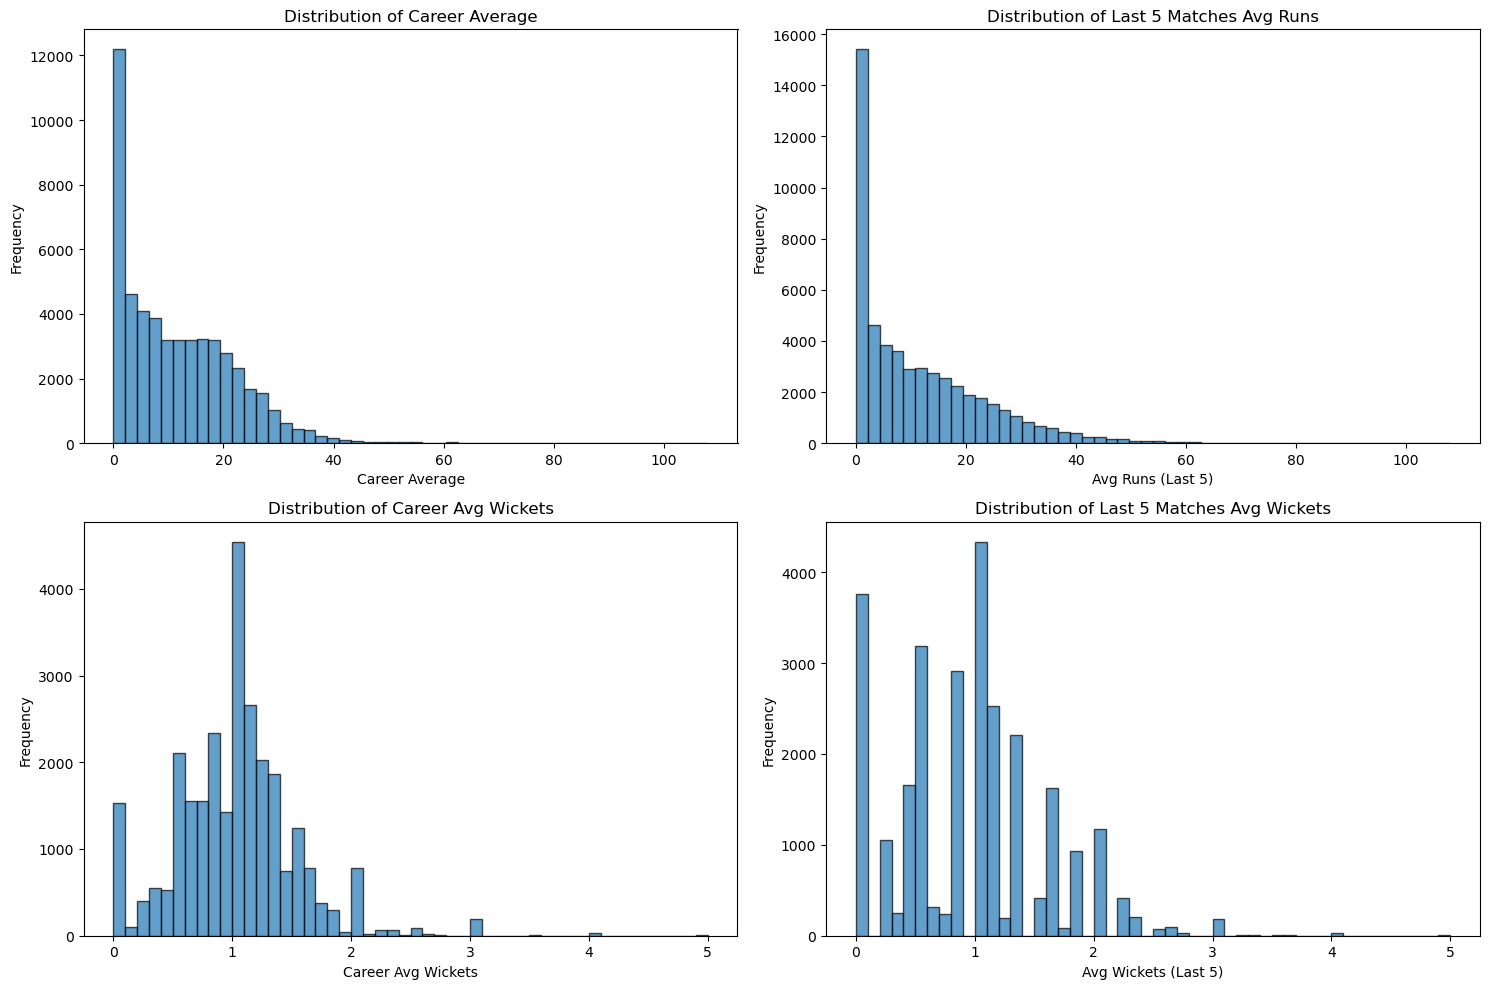

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].hist(batting_dataset['career_avg'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Career Average')
axes[0, 0].set_xlabel('Career Average')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(batting_dataset['runs_last_5'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution of Last 5 Matches Avg Runs')
axes[0, 1].set_xlabel('Avg Runs (Last 5)')
axes[0, 1].set_ylabel('Frequency')

axes[1, 0].hist(bowling_dataset['career_avg_wickets'], bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Distribution of Career Avg Wickets')
axes[1, 0].set_xlabel('Career Avg Wickets')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].hist(bowling_dataset['wickets_last_5'], bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Distribution of Last 5 Matches Avg Wickets')
axes[1, 1].set_xlabel('Avg Wickets (Last 5)')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()